In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

from sqlalchemy import create_engine
from tqdm import tqdm
from rdsutils.aws import download_s3 #, python_object_to_s3

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_feather('../data/labeled/labeled_1597354481.feather')

In [69]:
v1_features = ['transaction_amount', 'fico_score', 'vantage_score',
            'fraud_score_1', 'fraud_score_2', 'email_risk_score', 'phone_risk_score',  'all8220', 
            'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'bcc2800', 'iln5520', 'bcx3423', 'stu5031',
            'nr_direct_deposits', 'nr_past_returns', 'rolling_trns_as_pct_of_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_balance', 
            'transaction_as_pct_of_bal_min', 'rolling_mean_acc_bal', 
              'real_ending_balance', # old 'account_ending_balance'
              'days_since_first_deposit' # old 'days_since_first_transaction'
              ]

features = ['transaction_amount', 'real_ending_balance', 'fico_score', 
            'vantage_score', 'all7120', 'all8220', 'bcc2800', 'bcc7120', 
            'bcx3423', 'iln5520', 'iqt9413', 'iqt9415', 'mtf5820', 'stu5031', 
            'credit_card_loan_amount', 'delinquencies_90_days', 'education_loan_amount',
            'mortgage_loan_amount', 'secured_loan_amount', 'total_outstanding_balance', 
            'total_tradelines_open', 'unsecured_loan_amount', 'giact_is_pass', 
            'giact_is_decline', 'giact_is_other', 'giact_nr_pass', 'giact_nr_decline',
            'giact_nr_other', 'fraud_score_1', 'fraud_score_2', 'address_risk_score', 
            'email_risk_score', 'phone_risk_score', 'name_address_correlation', 
            'name_email_correlation', 'name_phone_correlation', 'nr_social_profiles_found', 
            'days_since_first_deposit', 'lag_acc_open_first_transaction', 'first_deposit_amount', 
            'giact_time_since_first_link', 'giact_time_since_last_link', 'transaction_as_pct_of_balance', 
            'time_since_last_transaction', 'nr_past_returns', 'nr_returns_30d', 'nr_past_deposits',
            'nr_deposits_3d', 'nr_deposits_30d', 'nr_past_transactions', 'nr_transactions_3d',
            'nr_transactions_30d', 'pct_returned_deposits', 'pct_returned_deposits_30d',
            'nr_transactions_30d_div_nr_past_transactions', 'mean_account_balance_3d',
            'mean_account_balance_30d', 'std_account_balance_3d', 'std_account_balance_30d', 
            'sum_deposits_3d', 'sum_deposits_10d', 'sum_deposits_30d', 'sum_withdrawals_3d', 
            'sum_withdrawals_10d', 'sum_withdrawals_30d', 'mean_deposits_10d', 
            'mean_deposits', 'mean_deposits_10d_div_mean_deposits', 'mean_withdrawals_10d', 
            'mean_withdrawals', 'mean_withdrawals_10d_div_mean_withdrawals', 'max_deposits_3d', 
            'max_deposits_10d', 'max_deposits_10d_div_mean_deposits',
            'max_deposits_10d_div_mean_account_balance_30d', 'max_withdrawals', 
            'max_withdrawals_3d', 'max_withdrawals_10d', 'max_withdrawals_10d_div_mean_withdrawals',
            'nr_trans_ratio', 'bal_ratio', 'deposits_ratio', 'nr_direct_deposits', 'dollar_val_dd'] + v1_features
features = sorted(list(set(features)))

boruta_features = pd.read_csv('../artifacts/fsel_result_1598212148.csv')
boruta_features = boruta_features[boruta_features.score > 0].feature.values

In [4]:
modeling_df = df[df["transaction_datetime"].between(pd.to_datetime('2019-01-16'),
                                                    pd.to_datetime('2020-02-14'))]
test_df1 = df[df["transaction_datetime"].between(pd.to_datetime('2020-03-01'),
                                                 pd.to_datetime('2020-04-01'))]
test_df2 = df[df["transaction_datetime"].between(pd.to_datetime('2020-04-01'),
                                                 pd.to_datetime('2020-05-01'))]

In [5]:
modeling_df[['giact_is_decline', 'giact_is_other', 'giact_is_pass']] = modeling_df[['giact_is_decline', 'giact_is_other', 'giact_is_pass']].astype(float)

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:>

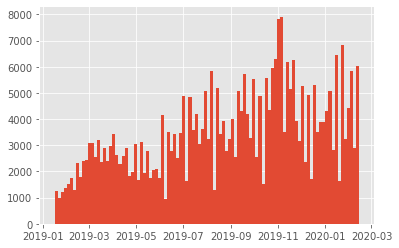

In [6]:
modeling_df.transaction_datetime.hist(bins=100)

In [7]:
modeling_df = modeling_df[~modeling_df.indeterminate]
modeling_df.target.value_counts()

False    336115
True       5896
Name: target, dtype: int64

In [8]:
count_pos = modeling_df['target'].sum()
count_neg = (~modeling_df['target']).sum()
pos_wgt_scaling_factor = count_neg / count_pos

In [9]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score


def train_lgb_baseline_grouped(df, features, params, target_col_name='target', 
                               group_col_name='business_account_number', num_folds=5, seed=12345, 
                               n_boost_rounds=100000, early_stopping_rounds=1000, 
                               verbose_eval=500, weight_col_name=None, cat_features=None, prepro=None):
    """
    Train LightGBM models over 5 folds, return OOF predictions, trained models, and average AUC over 5 folds.
    """
    kf = GroupKFold(num_folds)
    split = kf.split(X=df, y=df[target_col_name], groups=df[group_col_name])

    train_pred = np.zeros(len(df))
    feature_importance_df = pd.DataFrame()

    models = []

    for i, (train_idx, test_idx) in enumerate(split):
        train = df.iloc[train_idx].copy()
        test = df.iloc[test_idx].copy()

        if weight_col_name:
            wtr = train[weight_col_name]
            wts = test[weight_col_name]
        else:
            wtr = None
            wts = None
            
        if prepro is not None:
            preprocessor = prepro
            train[cat_features] = prepro.fit_transform(X=train[cat_features], y=train[target_col_name])
            test[cat_features] = prepro.transform(test[cat_features])

        lgb_train = lgb.Dataset(train[features],
                                label=train[target_col_name],
                                free_raw_data=False,
                                weight=wtr)
        lgb_test = lgb.Dataset(test[features],
                               label=test[target_col_name],
                               free_raw_data=False,
                               weight=wts)

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_test],
                          valid_names=['train', 'test'],
                          num_boost_round=n_boost_rounds,
                          early_stopping_rounds= early_stopping_rounds,
                          verbose_eval=verbose_eval)
        models.append(model)

        train_pred[test_idx] = model.predict(test[features], num_iteration=model.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = model.feature_importance(importance_type='gain', 
                                                                    iteration=model.best_iteration)
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    auc = roc_auc_score(y_true=df[target_col_name].values, y_score=train_pred)

    return train_pred, feature_importance_df, models, auc

#### Benchmarks
---
##### v1 features

In [10]:
import os
import sys
import lightgbm as lgb
# from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped

In [11]:
seed = 12345
params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 3,
    "num_leaves" : 10,
    "learning_rate" : 0.02,
    "feature_fraction" : 0.6,
    "lambda_l1": 10,
    "min_data_in_leaf": 5,
    "scale_pos_weight": pos_wgt_scaling_factor,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : seed,
    "verbosity" : 1,
    "seed": seed
}

In [12]:
pred, fimp_bl, model_bl, auc = train_lgb_baseline_grouped(modeling_df, v1_features, params, 'target')

Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.983663	test's auc: 0.982871
[1000]	train's auc: 0.98762	test's auc: 0.98391
[1500]	train's auc: 0.990055	test's auc: 0.984194
[2000]	train's auc: 0.99165	test's auc: 0.984336
[2500]	train's auc: 0.992794	test's auc: 0.98434
[3000]	train's auc: 0.993611	test's auc: 0.984066
Early stopping, best iteration is:
[2390]	train's auc: 0.992562	test's auc: 0.9844
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.984838	test's auc: 0.977602
[1000]	train's auc: 0.988539	test's auc: 0.97853
[1500]	train's auc: 0.99082	test's auc: 0.978598
[2000]	train's auc: 0.992317	test's auc: 0.978459
Early stopping, best iteration is:
[1312]	train's auc: 0.990079	test's auc: 0.97875
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.985486	test's auc: 0.975249
[1000]	train's auc: 0.988701	test's auc: 0.976216
[1500]	train's auc: 0.99092	test's auc: 0.976472
[200

In [13]:
modeling_df['bl_pred'] = pred

#### TB EDA Features
---

In [14]:
tb_features = ['transaction_amount', 'real_ending_balance', 'fico_score', 'vantage_score', 'all7120', 'all8220', 'bcc2800', 'bcc7120', 'bcx3423', 'iln5520', 'iqt9413', 'iqt9415', 'mtf5820', 'stu5031', 'credit_card_loan_amount', 'delinquencies_90_days', 'education_loan_amount', 'mortgage_loan_amount', 'secured_loan_amount', 'total_outstanding_balance', 'total_tradelines_open', 'unsecured_loan_amount', 'giact_is_pass', 'giact_is_decline', 'giact_is_other', 'giact_nr_pass', 'giact_nr_decline', 'giact_nr_other', 'fraud_score_1', 'fraud_score_2', 'address_risk_score', 'email_risk_score', 'phone_risk_score', 'name_address_correlation', 'name_email_correlation', 'name_phone_correlation', 'nr_social_profiles_found', 'days_since_first_deposit', 'lag_acc_open_first_transaction', 'first_deposit_amount', 'giact_time_since_first_link', 'giact_time_since_last_link', 'transaction_as_pct_of_balance', 'time_since_last_transaction', 'nr_past_returns', 'nr_returns_30d', 'nr_past_deposits', 'nr_deposits_3d', 'nr_deposits_30d', 'nr_past_transactions', 'nr_transactions_3d', 'nr_transactions_30d', 'pct_returned_deposits', 'pct_returned_deposits_30d', 'nr_transactions_30d_div_nr_past_transactions', 'mean_account_balance_3d', 'mean_account_balance_30d', 'std_account_balance_3d', 'std_account_balance_30d', 'sum_deposits_3d', 'sum_deposits_10d', 'sum_deposits_30d', 'sum_withdrawals_3d', 'sum_withdrawals_10d', 'sum_withdrawals_30d', 'mean_deposits_10d', 'mean_deposits', 'mean_deposits_10d_div_mean_deposits', 'mean_withdrawals_10d', 'mean_withdrawals', 'mean_withdrawals_10d_div_mean_withdrawals', 'max_deposits_3d', 'max_deposits_10d', 'max_deposits_10d_div_mean_deposits', 'max_deposits_10d_div_mean_account_balance_30d', 'max_withdrawals', 'max_withdrawals_3d', 'max_withdrawals_10d', 'max_withdrawals_10d_div_mean_withdrawals', 'nr_trans_ratio', 'bal_ratio', 'deposits_ratio', 'nr_direct_deposits', 'dollar_val_dd']
pred, fimp_eda, model_eda, auc = train_lgb_baseline_grouped(modeling_df, tb_features, params, 'target')
modeling_df['eda_pred'] = pred

Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.989852	test's auc: 0.988208
[1000]	train's auc: 0.99341	test's auc: 0.989057
[1500]	train's auc: 0.995085	test's auc: 0.9892
[2000]	train's auc: 0.996224	test's auc: 0.989037
Early stopping, best iteration is:
[1370]	train's auc: 0.994703	test's auc: 0.989272
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.990461	test's auc: 0.984285
[1000]	train's auc: 0.993712	test's auc: 0.985425
[1500]	train's auc: 0.995474	test's auc: 0.986102
[2000]	train's auc: 0.996544	test's auc: 0.986094
[2500]	train's auc: 0.997191	test's auc: 0.986134
[3000]	train's auc: 0.997643	test's auc: 0.985998
Early stopping, best iteration is:
[2303]	train's auc: 0.99697	test's auc: 0.986203
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.991161	test's auc: 0.980423
[1000]	train's auc: 0.994222	test's auc: 0.980995
[1500]	train's auc: 0.995836	test's auc: 0.98177

#### Boruta Features
---

In [70]:
pred, fimp_boruta, model_boruta, auc = train_lgb_baseline_grouped(modeling_df, boruta_features, params, 'target')
modeling_df['boruta_pred'] = pred

Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.988855	test's auc: 0.987202
[1000]	train's auc: 0.992671	test's auc: 0.988343
[1500]	train's auc: 0.994557	test's auc: 0.988475
[2000]	train's auc: 0.995729	test's auc: 0.988438
[2500]	train's auc: 0.996524	test's auc: 0.988467
Early stopping, best iteration is:
[1530]	train's auc: 0.994638	test's auc: 0.988513
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.989411	test's auc: 0.983267
[1000]	train's auc: 0.993043	test's auc: 0.984477
[1500]	train's auc: 0.994879	test's auc: 0.985141
[2000]	train's auc: 0.996037	test's auc: 0.985281
[2500]	train's auc: 0.996767	test's auc: 0.985112
[3000]	train's auc: 0.997279	test's auc: 0.984803
Early stopping, best iteration is:
[2182]	train's auc: 0.99634	test's auc: 0.985337
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.990321	test's auc: 0.980278
[1000]	train's auc: 0.993547	test's auc: 0.98

(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

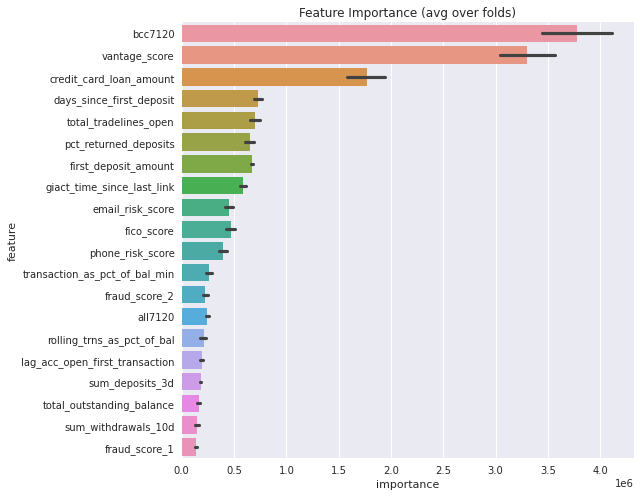

In [85]:
from rdsutils.plot import display_feature_importance

display_feature_importance(fimp_boruta.feature, fimp_boruta.importance)

#### Basic Evaluations
---

In [5]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_pr_curve, plot_pr_curve_mult, plot_auc_curve, plot_auc_curve_mult, hist_by_target

plt.style.use('seaborn')

CPU times: user 595 ms, sys: 68.8 ms, total: 664 ms
Wall time: 671 ms


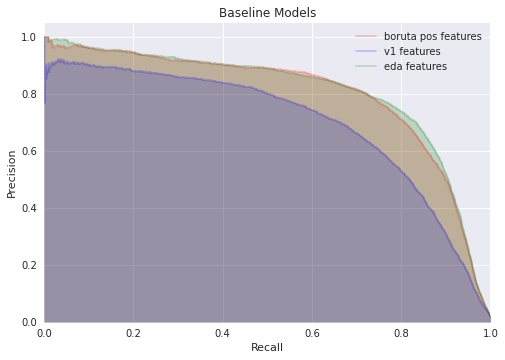

In [6]:
y_scores = [(modeling_df.boruta_pred, 'boruta pos features'),
            (modeling_df.bl_pred, 'v1 features'),
            (modeling_df.eda_pred, 'eda features')]
colors=['r', 'b', 'g']
%time plot_pr_curve_mult(modeling_df.target, y_scores, 'Baseline Models', colors=colors)

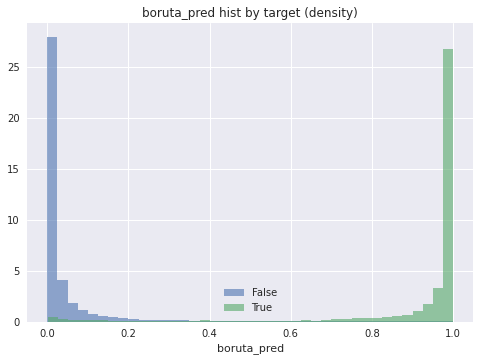

In [73]:
hist_by_target('boruta_pred', 'target', modeling_df)

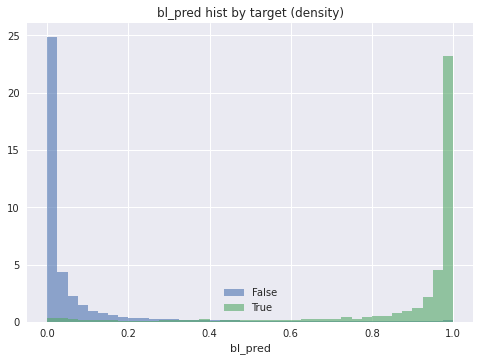

In [74]:
hist_by_target('bl_pred', 'target', modeling_df)

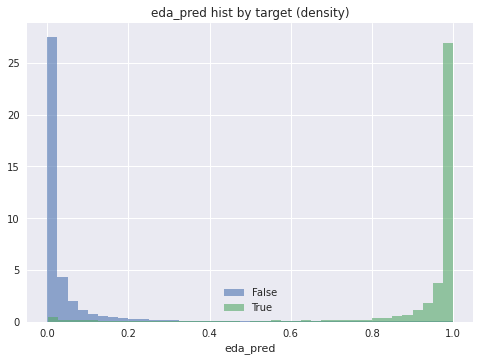

In [75]:
hist_by_target('eda_pred', 'target', modeling_df)

In [76]:
modeling_df.to_parquet('../artifacts/modeling_df_baseline.parquet')

#### Signifcant cases
---

In [3]:
modeling_df = pd.read_parquet('../artifacts/modeling_df_baseline.parquet')

In [4]:
from rdsutils.analysis import get_misclassified_high_risk_rows, build_summary

In [ ]:
meta_cols = ['borrower_id', 'business_account_number', 'target', 
             'boruta_pred', 'endbal', 'transaction_amount',
             'account_closed_by_risk_in_next_90d', 'nr_returns_in_next_90d']
df = modeling_df[meta_cols]
df = df.loc[df.target]
df = get_misclassified_high_risk_rows(df, 'transaction_amount', 'boruta_pred')

In [79]:
df.head(5)

,borrower_id,business_account_number,target,boruta_pred,endbal,transaction_amount,account_closed_by_risk_in_next_90d,nr_returns_in_next_90d
125058,6881553,410000648780,True,0.000525,146550.52,50000.0,False,1.0
166722,7142445,410001005315,True,0.092994,50000.00,50000.0,False,1.0
171171,5418572,410001053473,True,0.159205,50000.00,50000.0,False,1.0
177193,7218747,410001126721,True,0.235456,50000.00,50000.0,False,1.0
238622,7612934,410001691284,True,0.863785,75001.66,50000.0,True,3.0


In [62]:
build_summary(modeling_df.target, modeling_df.boruta_pred)

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Good Above Threshold,#Fraudulent Below Threshold
0,90.0,0.152092,83.354775,96.556988,34202,5693,28509,203
1,91.0,0.177906,81.566551,96.234735,30781,5674,25107,222
2,92.0,0.212687,79.350170,95.827680,27361,5650,21711,246
3,93.0,0.259113,76.500564,95.420624,23941,5626,18315,270
4,94.0,0.321327,72.769358,94.776119,20521,5588,14933,308
5,95.0,0.410946,67.592538,93.995929,17101,5542,11559,354
6,96.0,0.537499,59.988305,92.842605,13681,5474,8207,422
7,97.0,0.715951,48.270149,90.027137,10261,5308,4953,588
8,98.0,0.911337,28.475369,82.988467,6841,4893,1948,1003
9,99.0,0.990338,11.049401,51.611262,3421,3043,378,2853


CPU times: user 412 ms, sys: 19.6 ms, total: 432 ms
Wall time: 431 ms


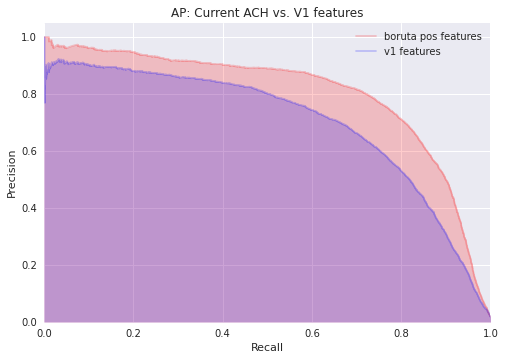

In [7]:
y_scores = [(modeling_df.boruta_pred, 'boruta pos features'),
            (modeling_df.bl_pred, 'v1 features')]
colors=['r', 'b']
%time plot_pr_curve_mult(modeling_df.target, y_scores, 'AP: Current ACH vs. V1 features', colors=colors)
plt.savefig('../plots/ach-vs-v1-ap.png')

CPU times: user 358 ms, sys: 0 ns, total: 358 ms
Wall time: 357 ms


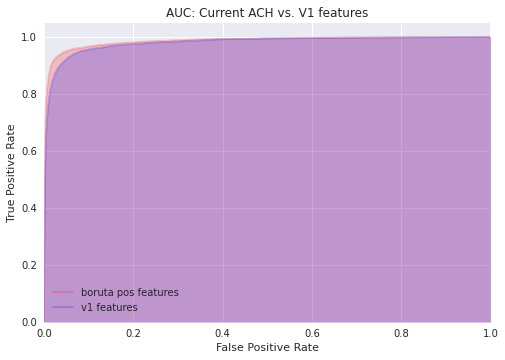

In [36]:
%time plot_auc_curve_mult(modeling_df.target, y_scores, 'AUC: Current ACH vs. V1 features', colors=colors)
plt.savefig('../plots/ach-vs-v1-auc.png')